In [1]:
import os
import numpy as np
import torch
import jsonargparse
import matplotlib.pyplot as plt
import scipy.stats as sstats

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [27]:
from cdi.util.analysis.plotting import plot_comparison
from cdi.util.analysis.eval import (compute_avg_kl_divergence,
                                    compute_avg_symmetrised_kl_divergence,
                                    compute_avg_wasserstein_distance,
                                    compute_gaussian_kl_div,
                                    compute_avg_num_var_updates_per_dim,
                                    compute_univariate_gaussian_kl_div)
from cdi.trainers.trainer_base import TrainerBase
from cdi.trainers.posterior_cdi import PosteriorCDI
from cdi.util.stats_utils import load_statistics


## Analysis setup

### Global settings

In [4]:
data_name = 'toy_set3'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm20190508_d2020032511_20200406_20200407',
    'm20190508_d2020032522_20200406_20200407',
    'm20190508_d2020032533_20200406_20200407',
    'm20190508_d2020032544_20200406_20200407',
    'm20190508_d2020032555_20200406_20200407',
    'm20190508_d2020032566_20200406_20200407',
    'm20190508_d2020032577_20200406_20200407',
    'm20190508_d2020032588_20200406_20200407',
    'm20190508_d2020032599_20200406_20200407'
]

### Templates

In [5]:
log_path_base = f'../../trained_models/{data_name}/learning_experiments'

## Helpers

In [25]:
def merge_dicts(a, b, path=None):
    "merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

def read_experiment_stats(group, model, seed, filename):
    path = log_path_base + f'/{group}/{model}/{seed}/logs/{filename}'
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

## Variational posterior analysis

### KL-divergence analysis $D_{\text{KL}}(q(x^j \mid x^{\smallsetminus j})||p(x^j \mid x^{\smallsetminus j}))$a

#### Use 1 sample in Monte-Carlo expectation approx.

##### VS. missingness

In [18]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
    '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     'MI5 1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
#     'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
#     '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
#     'MI1 1all 3gibbs': 'fa_pretrained_var_cdi_mi1_1all_3gibbs',

}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


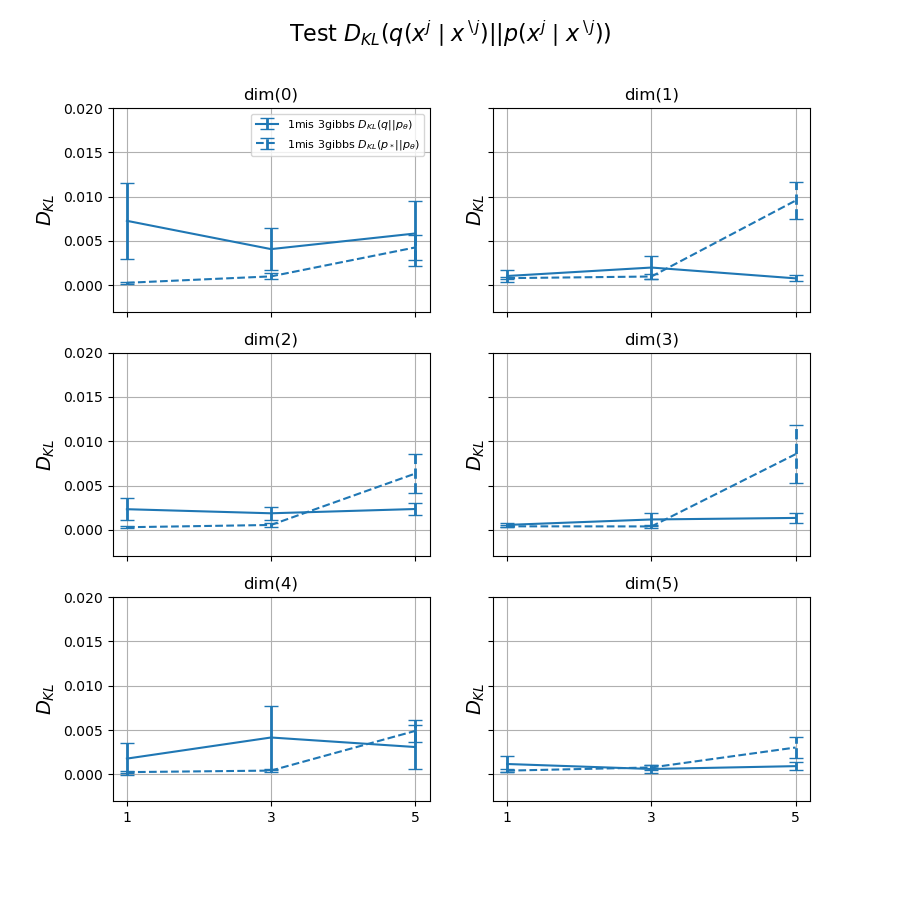

In [19]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth',
            'test_avg_kldiv_var_anal',
            'test_avg_kldiv_model_truth'
)
err_metrics = (#'test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               'test_avg_kldiv_std_err_model_truth'
)
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 '$D_{KL}(p_*||p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$D_{KL}$', 
                    ylim=(-0.003, 0.02))

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(prop={'size': 8})


##### VS. number of var model updates

In [9]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
    '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
    '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
    '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
    'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
#     '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


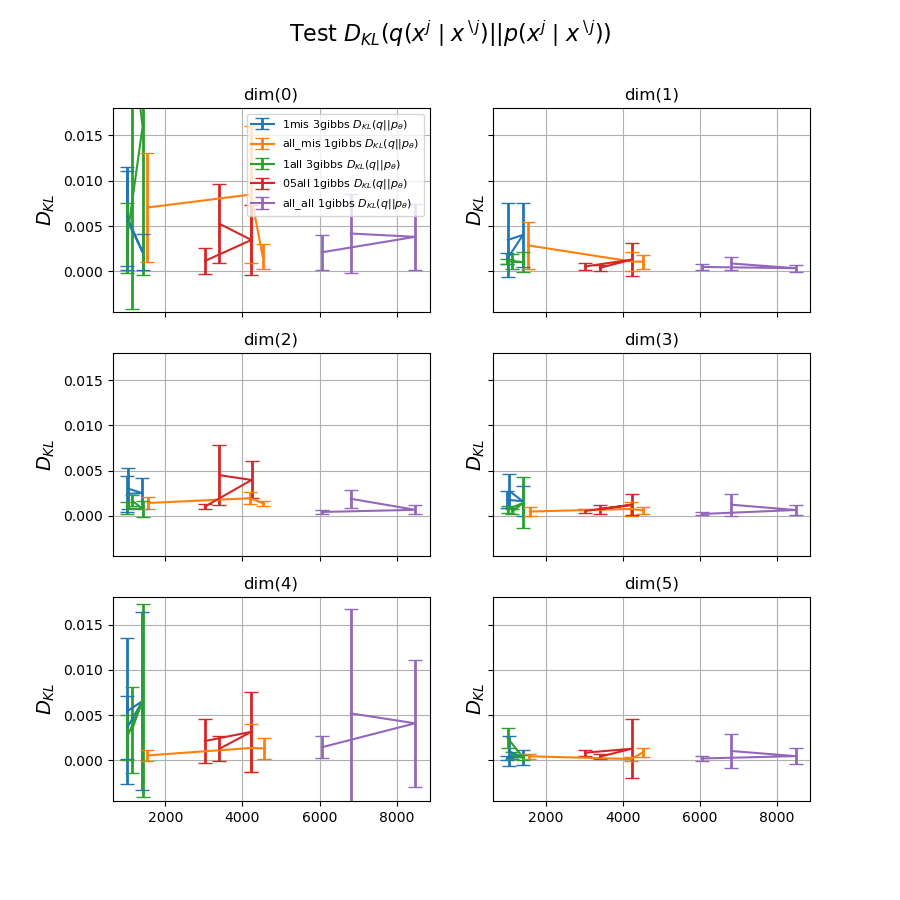

In [10]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    model_stats = compute_avg_kl_divergence(model1=model_name,
                                           model2=model_name,
                                           model1_posterior_key='var',
                                           model2_posterior_key='anal',
                                           out_key='var_anal',
                                           seeds=exp_seed_keys,
                                           groups=groups,
                                           base_path=log_path_base)
    model_update_stats = compute_avg_num_var_updates_per_dim(model=model_name,
                                                        seeds=exp_seed_keys,
                                                        groups=groups,
                                                        base_path=log_path_base)
    if '_s5' in exp_name:
        model_update_stats['num_var_updates'] /= 5

    stats[exp_name] = {**model_stats, **model_update_stats}

    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth',
            'test_avg_kldiv_var_anal',
            #'test_avg_kldiv_model_truth'
)
err_metrics = (#'test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               #'test_avg_kldiv_std_err_model_truth'
)
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 #'$D_{KL}(p_*||p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='num_var_updates',
                    x_metric_dim=i,
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,
                    ylabel='$D_{KL}$', 
                    ylim=None)

    axes[i].legend(prop={'size': 8})
    if i > 0:
        axes[i].get_legend().remove()

#### Use 5 samples in Monte-Carlo expectation approx.

##### VS. missingness

In [19]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
    '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
#     'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
#     'MI5 1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
    'MI5 1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
    'MI1 1all 3gibbs': 'fa_pretrained_var_cdi_mi1_1all_3gibbs',
    'MI1 1all 3gibbs s5': 'fa_pretrained_var_cdi_mi1_1all_3gibbs_s5',
    
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


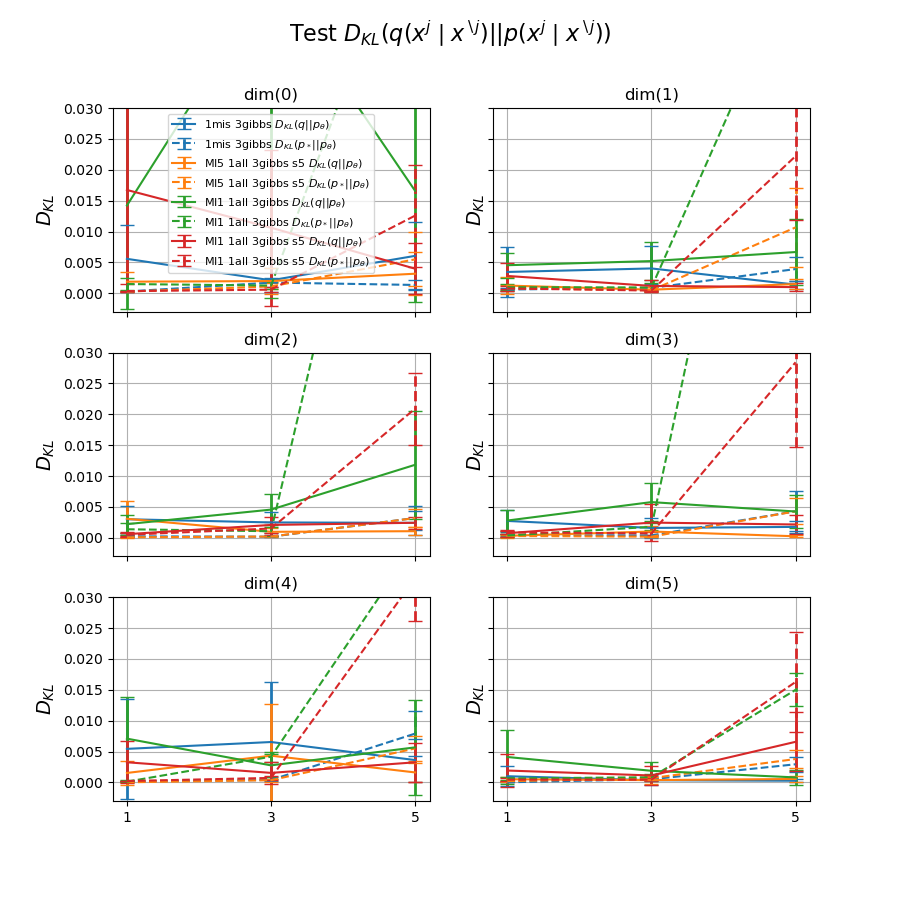

In [20]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)

    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth',
            'test_avg_kldiv_var_anal',
            'test_avg_kldiv_model_truth'
)
err_metrics = (#'test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               'test_avg_kldiv_std_err_model_truth'
)
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 '$D_{KL}(p_*||p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$D_{KL}$', 
                    ylim=(-0.003, 0.03))

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(prop={'size': 8})


##### VS. number of var model updates

In [64]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
#     '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
#     'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
    '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


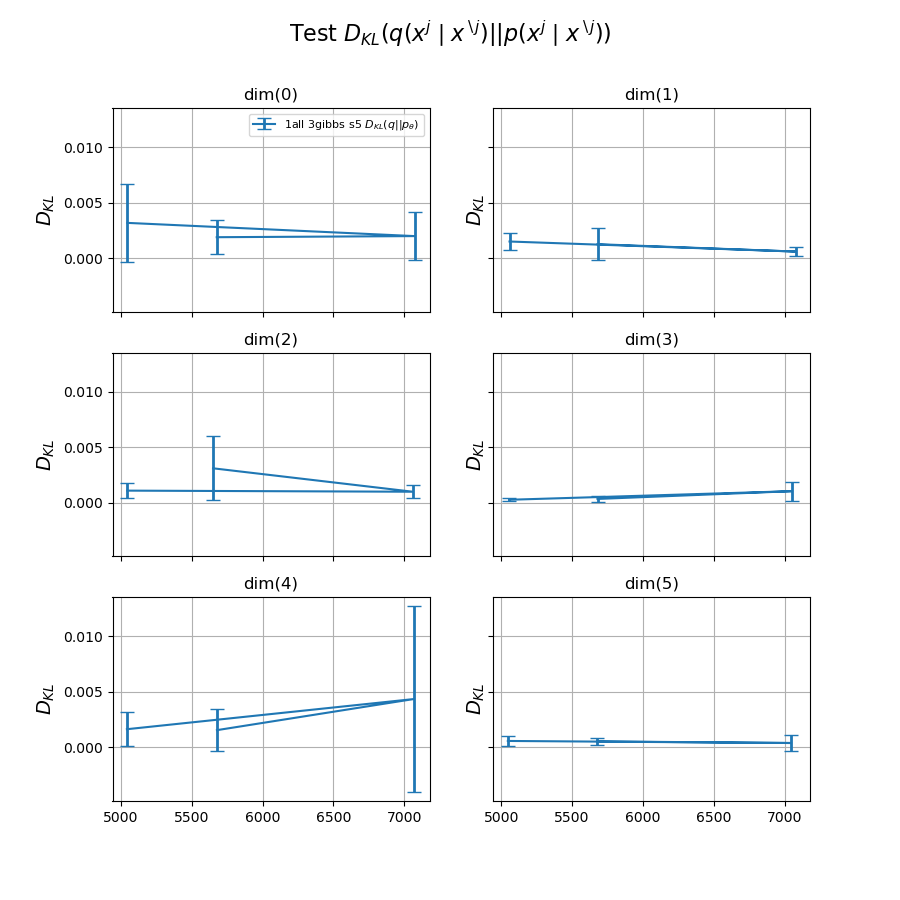

In [65]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    model_stats = compute_avg_kl_divergence(model1=model_name,
                                           model2=model_name,
                                           model1_posterior_key='var',
                                           model2_posterior_key='anal',
                                           out_key='var_anal',
                                           seeds=exp_seed_keys,
                                           groups=groups,
                                           base_path=log_path_base)
    model_update_stats = compute_avg_num_var_updates_per_dim(model=model_name,
                                                        seeds=exp_seed_keys,
                                                        groups=groups,
                                                        base_path=log_path_base)
    if '_s5' in exp_name:
        model_update_stats['num_var_updates'] /= 5

    stats[exp_name] = {**model_stats, **model_update_stats}

    
# Define metrics for plot
y_metrics = (#'test_avg_kldiv_var_truth',
            'test_avg_kldiv_var_anal',
            'test_avg_kldiv_model_truth'
)
err_metrics = (#'test_avg_kldiv_std_err_var_truth',
               'test_avg_kldiv_std_err_var_anal',
               'test_avg_kldiv_std_err_model_truth'
)
metric_labels = (#'$D_{KL}(q||p_*)$',
                 '$D_{KL}(q||p_{\\theta})$',
                 '$D_{KL}(p_*||p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $D_{KL}(q(x^j \\mid x^{\\smallsetminus j})||p(x^j \\mid x^{\\smallsetminus j}))$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='num_var_updates',
                    x_metric_dim=i,
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,
                    ylabel='$D_{KL}$', 
                    ylim=None)

    axes[i].legend(prop={'size': 8})
    if i > 0:
        axes[i].get_legend().remove()

### Univariate Wasserstein distance $\mathcal{W} = (\mu_1 - \mu_2)^2 + (\sigma_1 - \sigma_2)^2$

#### Use 1 sample in Monte-Carlo expectation approx.

##### VS. missingness

In [15]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
    '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
    '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
    '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
    'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
#     '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


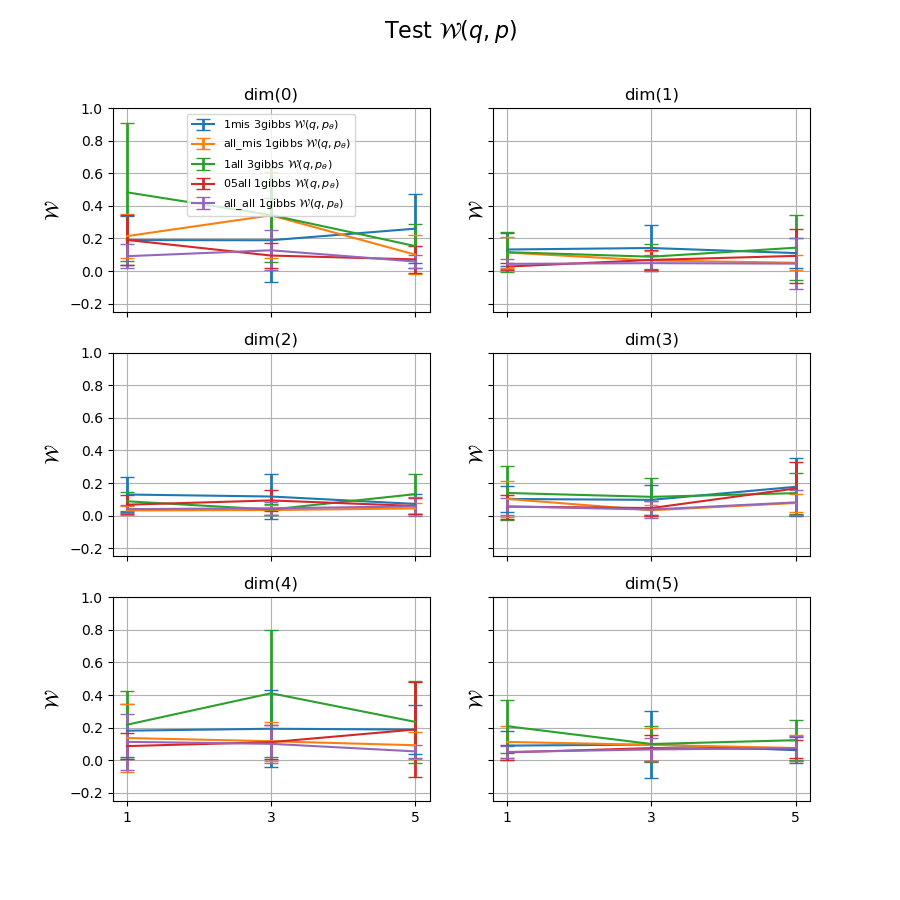

In [16]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    
    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = (#'test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',
            #'test_avg_wass_dist_model_truth'
)
err_metrics = (#'test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',
               #'test_avg_wass_dist_std_err_model_truth'
)
metric_labels = (#'$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 #'$\\mathcal{W}(p_*, p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$\\mathcal{W}$', 
                    ylim=(-0.25, 1))

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(prop={'size': 8})


##### VS. number of var model updates

In [17]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
    '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
    '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
    '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
    'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
#     '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
#     'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
#     '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
#     '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
#     'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


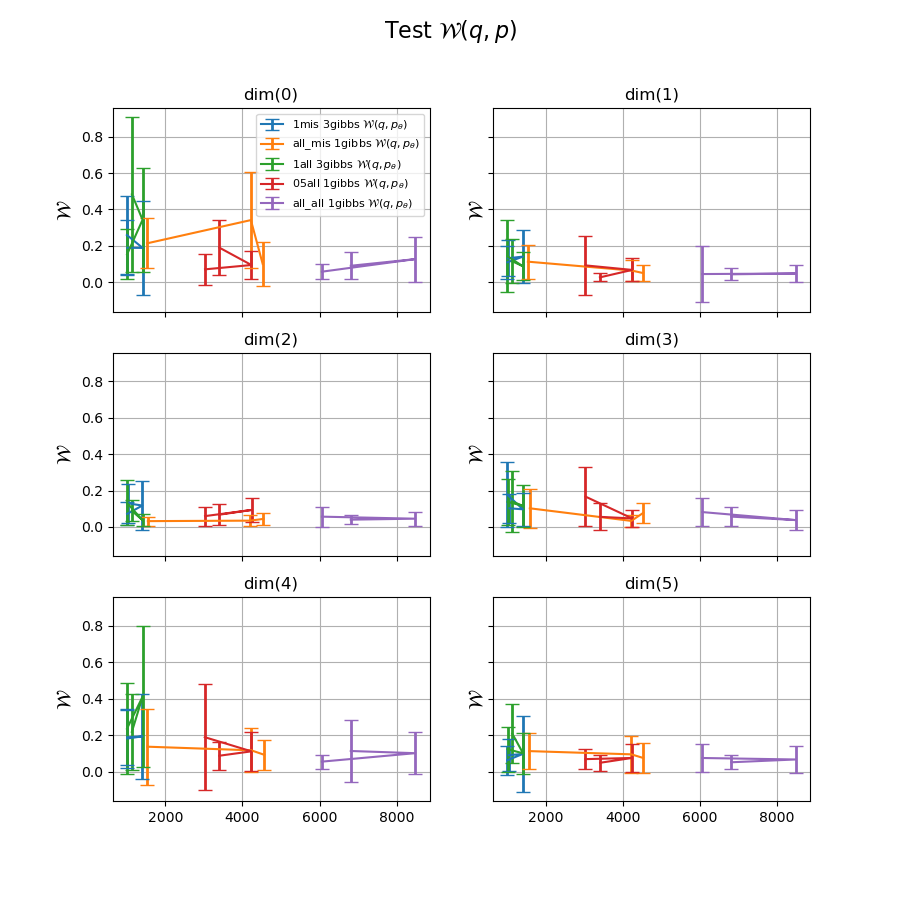

In [18]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    model_stats = compute_avg_wasserstein_distance(model1=model_name,
                                           model2=model_name,
                                           model1_posterior_key='var',
                                           model2_posterior_key='anal',
                                           out_key='var_anal',
                                           seeds=exp_seed_keys,
                                           groups=groups,
                                           base_path=log_path_base)
    model_update_stats = compute_avg_num_var_updates_per_dim(model=model_name,
                                                        seeds=exp_seed_keys,
                                                        groups=groups,
                                                        base_path=log_path_base)
    stats[exp_name] = {**model_stats, **model_update_stats}

    
# Define metrics for plot
y_metrics = (#'test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',)
            #'test_avg_wass_dist_model_truth')
err_metrics = (#'test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',)
               #'test_avg_wass_dist_std_err_model_truth')
metric_labels = (#'$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',)
                 #'$\\mathcal{W}(p_*, p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='num_var_updates',
                    x_metric_dim=i,
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,
                    ylabel='$\\mathcal{W}$', 
                    ylim=None)

    axes[i].legend(prop={'size': 8})
    if i > 0:
        axes[i].get_legend().remove()

#### Use 5 samples in Monte-Carlo expectation approx.

##### VS. missingness

In [25]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
#     '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
#     'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
    '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
    'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
    '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
    '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
    'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


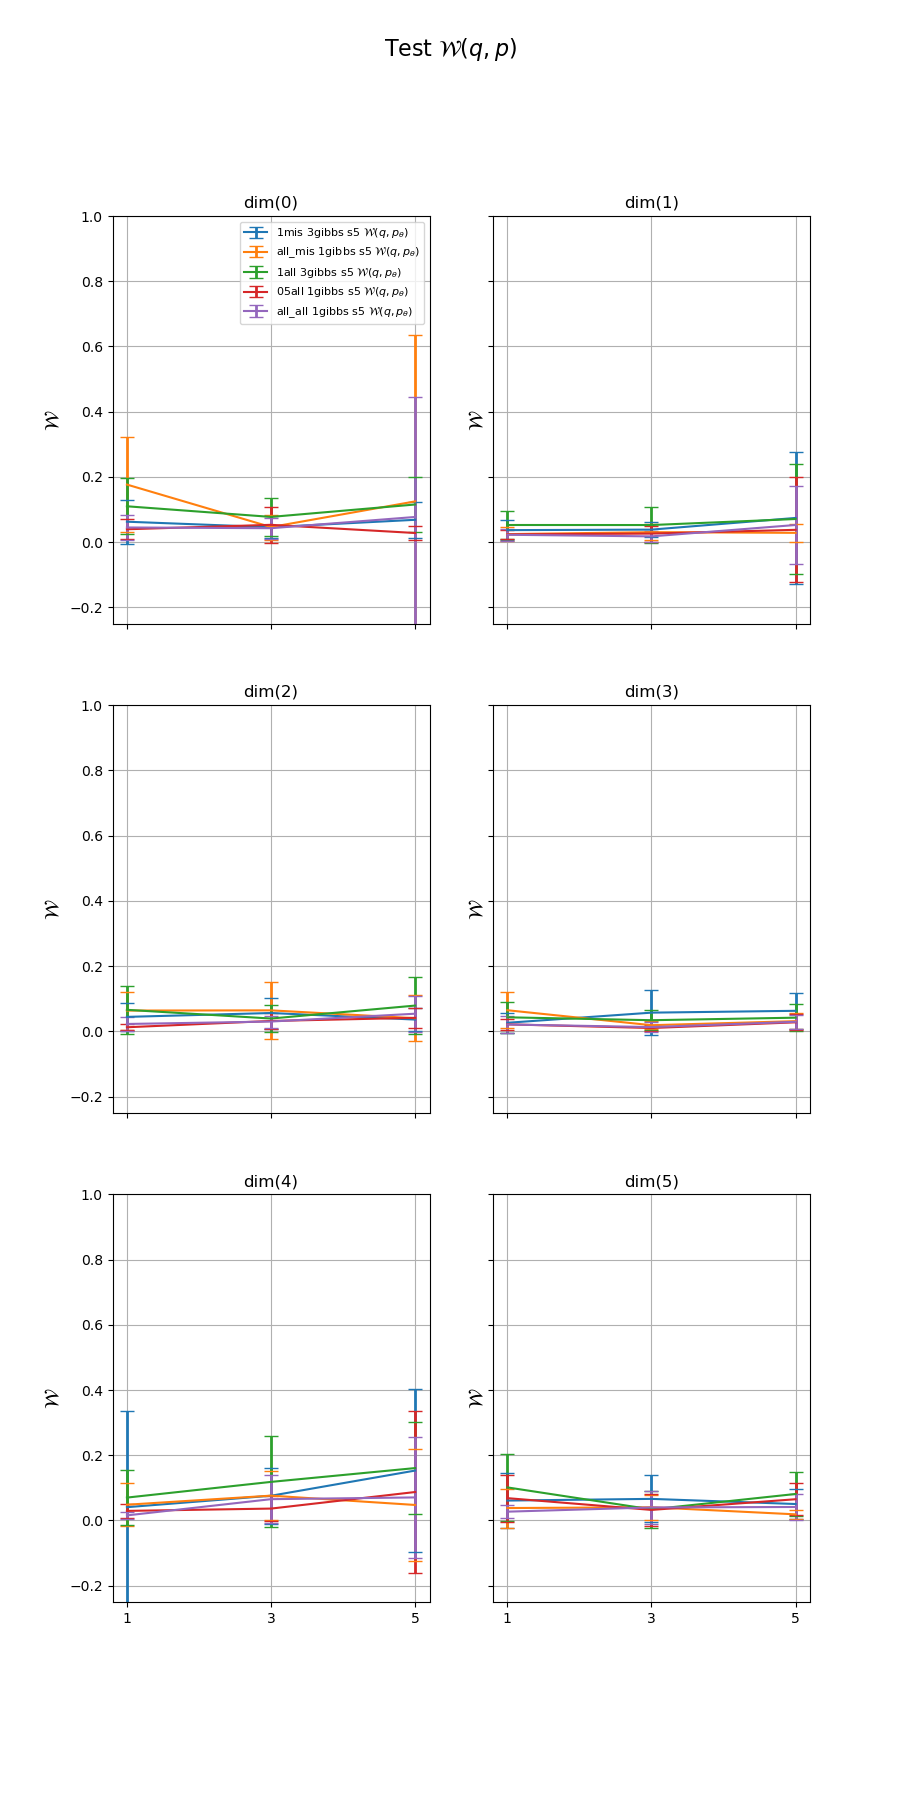

In [26]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    stats1 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats2 = compute_avg_wasserstein_distance(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    stats3 = compute_avg_wasserstein_distance(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base)
    
    stats[exp_name] = {**stats1, **stats2, **stats3}

# Define metrics for plot
y_metrics = (#'test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',
            #'test_avg_wass_dist_model_truth'
)
err_metrics = (#'test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',
               #'test_avg_wass_dist_std_err_model_truth'
)
metric_labels = (#'$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',
                 #'$\\mathcal{W}(p_*, p_{\\theta})$'
)

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='group',
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,#'Missingness /6',
                    ylabel='$\\mathcal{W}$', 
                    ylim=(-0.25, 1))

    axes[i].xaxis.set_ticks(groups)
    if i > 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(prop={'size': 8})


##### VS. number of var model updates

In [21]:
suite = {
#     'VCDI': 'fa_variational_cdi_mi5',
#     '1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'all_mis 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     '1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     '05all 1gibbs': 'fa_pretrained_var_cdi_mi5_05all_1gibbs',
#     'all_all 1gibbs': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs',
    '1mis 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_s5',
    'all_mis 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs_s5',
    '1all 3gibbs s5': 'fa_pretrained_var_cdi_mi5_1all_3gibbs_s5',
    '05all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_05all_1gibbs_s5',
    'all_all 1gibbs s5': 'fa_pretrained_var_cdi_mi5_all_all_1gibbs_s5',
}
groups = [1, 3, 5]

<IPython.core.display.Javascript object>


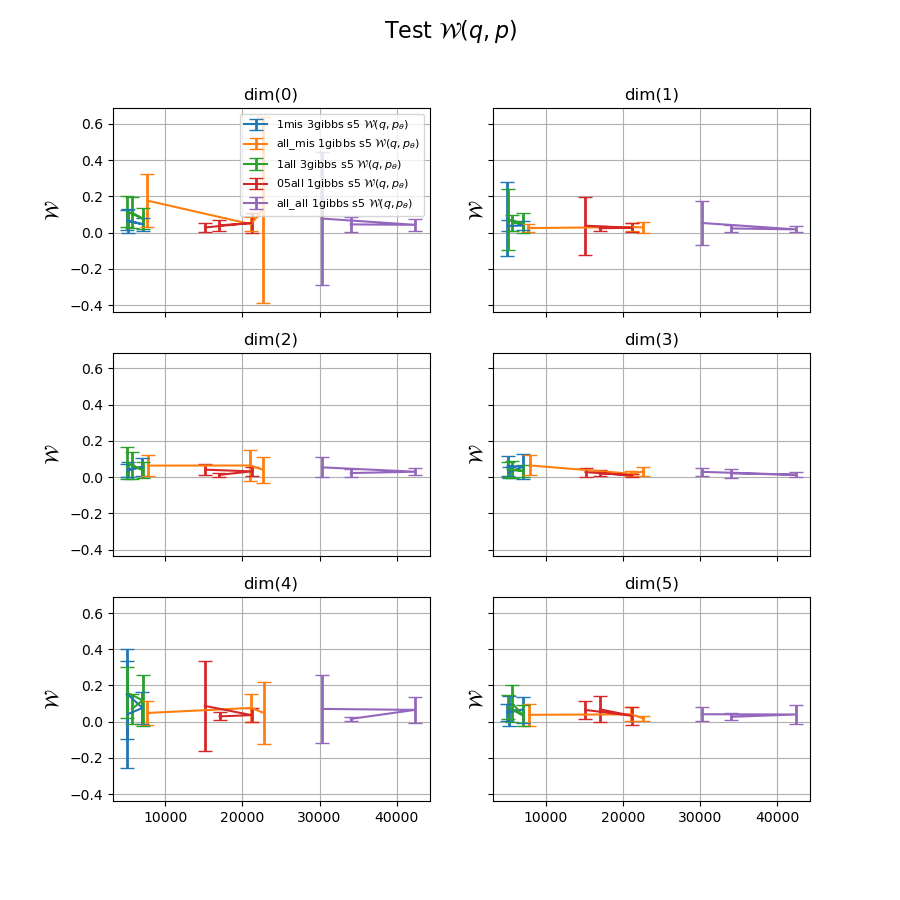

In [22]:
stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in suite.items():
    model_stats = compute_avg_wasserstein_distance(model1=model_name,
                                           model2=model_name,
                                           model1_posterior_key='var',
                                           model2_posterior_key='anal',
                                           out_key='var_anal',
                                           seeds=exp_seed_keys,
                                           groups=groups,
                                           base_path=log_path_base)
    model_update_stats = compute_avg_num_var_updates_per_dim(model=model_name,
                                                        seeds=exp_seed_keys,
                                                        groups=groups,
                                                        base_path=log_path_base)
    stats[exp_name] = {**model_stats, **model_update_stats}

    
# Define metrics for plot
y_metrics = (#'test_avg_wass_dist_var_truth',
            'test_avg_wass_dist_var_anal',)
            #'test_avg_wass_dist_model_truth')
err_metrics = (#'test_avg_wass_dist_std_err_var_truth',
               'test_avg_wass_dist_std_err_var_anal',)
               #'test_avg_wass_dist_std_err_model_truth')
metric_labels = (#'$\\mathcal{W}(q, p_*)$',
                 '$\\mathcal{W}(q, p_{\\theta})$',)
                 #'$\\mathcal{W}(p_*, p_{\\theta})$')

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(9, 9))
fig.suptitle('Test $\\mathcal{W}(q, p)$', 
             fontsize=16)
axes = axes.flatten()
for i in range(6):
    axes[i].set(title=f'dim({i})')
    plot_comparison(axes[i], stats, 
                    x_metric_key='num_var_updates',
                    x_metric_dim=i,
                    y_metric_keys=y_metrics,
                    y_metric_dim=i,
                    err_keys=err_metrics,
                    err_metric_dim=i,
                    metric_labels=metric_labels,
                    xlabel=None,
                    ylabel='$\\mathcal{W}$', 
                    ylim=None)

    axes[i].legend(prop={'size': 8})
    if i > 0:
        axes[i].get_legend().remove()

### Debug: var. model learning kl-divergence

<IPython.core.display.Javascript object>


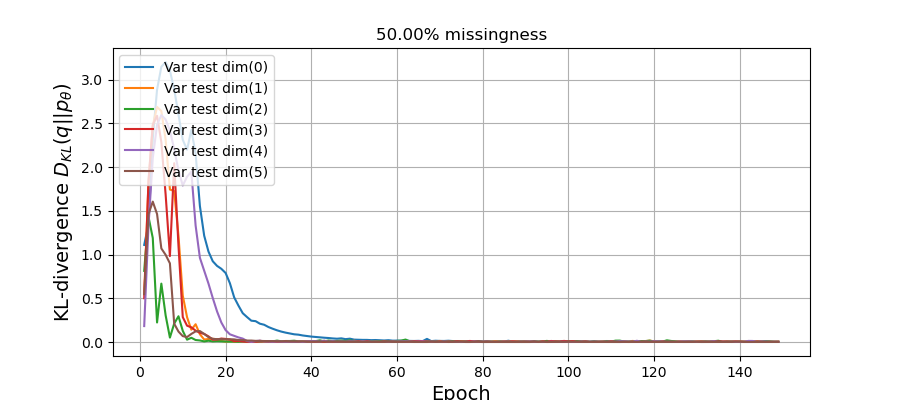

In [44]:
# y_metrics = ('train_kldiv_0',
#             'train_kldiv_1',
#             'train_kldiv_2',
#             'train_kldiv_3',
#             'train_kldiv_4',
#             'train_kldiv_5')
y_metrics = ('val_kldiv_0',
            'val_kldiv_1',
            'val_kldiv_2',
            'val_kldiv_3',
            'val_kldiv_4',
            'val_kldiv_5')
err_metrics = (None, None, None, None, None, None,)
metric_labels = ('dim(0)',
                 'dim(1)',
                 'dim(2)',
                 'dim(3)',
                 'dim(4)',
                 'dim(5)',)

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 4))
axes = [axes]
for i, g in enumerate([3]):
    axes[i].set(title=f'{g/6*100:.2f}% missingness')
    stats = {
        'Var test': read_experiment_stats(g, 'fa_pretrained_var_cdi_1mis_3gibbs_test', 
                                          exp_seed_keys[0], filename='summary.csv')
    }

    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=y_metrics,  
                    err_keys=err_metrics,
                    metric_labels=metric_labels,
                    xlabel='Epoch',
                    ylabel='KL-divergence $D_{KL}(q||p_{\\theta})$', 
                    ylim=None,
                    colors_instead_styles=True)

    axes[i].legend(loc='upper left')

## KL divergence on some toy distributions

<IPython.core.display.Javascript object>


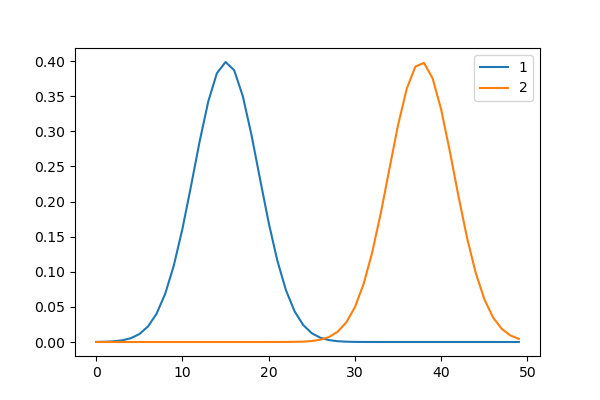

In [58]:
mean1 = 1
sigma1 = 1

mean2 = 7
sigma2 = 1

x_line = np.linspace(-3, 10)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 4))
axes.plot(sstats.norm.pdf(x_line, mean1, sigma1), label='1')
axes.plot(sstats.norm.pdf(x_line, mean2, sigma2), label='2')
axes.legend()

In [59]:
compute_univariate_gaussian_kl_div(mean1, np.log(sigma1), mean2, np.log(sigma2))

18.0

<IPython.core.display.Javascript object>


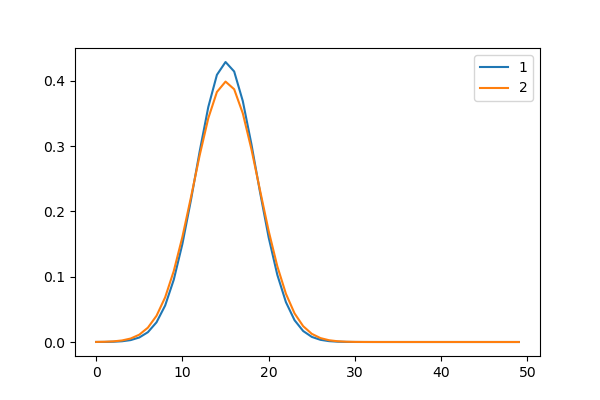

In [41]:
mean1 = 1
sigma1 = 0.93

mean2 = 1
sigma2 = 1

x_line = np.linspace(-3, 10)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 4))
axes.plot(sstats.norm.pdf(x_line, mean1, sigma1), label='1')
axes.plot(sstats.norm.pdf(x_line, mean2, sigma2), label='2')
axes.legend()

In [42]:
compute_univariate_gaussian_kl_div(mean1, np.log(sigma1), mean2, np.log(sigma2))

0.005020692834835416

<IPython.core.display.Javascript object>


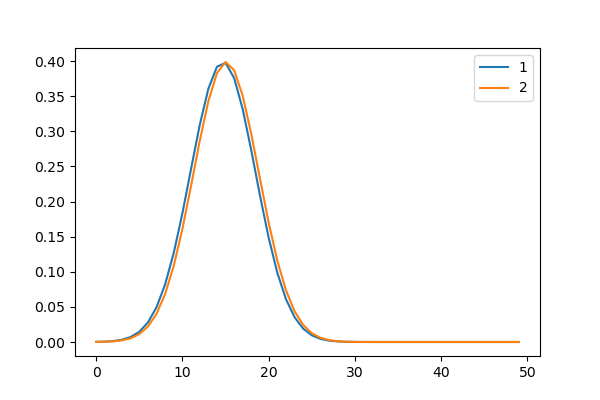

In [54]:
mean1 = 0.9
sigma1 = 1

mean2 = 1
sigma2 = 1

x_line = np.linspace(-3, 10)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 4))
axes.plot(sstats.norm.pdf(x_line, mean1, sigma1), label='1')
axes.plot(sstats.norm.pdf(x_line, mean2, sigma2), label='2')
axes.legend()

In [55]:
compute_univariate_gaussian_kl_div(mean1, np.log(sigma1), mean2, np.log(sigma2))

0.0050000000000000044

<IPython.core.display.Javascript object>


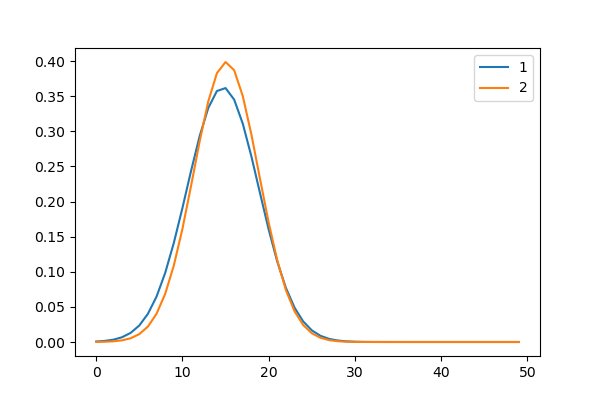

In [56]:
mean1 = 0.9
sigma1 = 1.1

mean2 = 1
sigma2 = 1

x_line = np.linspace(-3, 10)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 4))
axes.plot(sstats.norm.pdf(x_line, mean1, sigma1), label='1')
axes.plot(sstats.norm.pdf(x_line, mean2, sigma2), label='2')
axes.legend()

In [57]:
compute_univariate_gaussian_kl_div(mean1, np.log(sigma1), mean2, np.log(sigma2))

0.014689820195675107

<IPython.core.display.Javascript object>


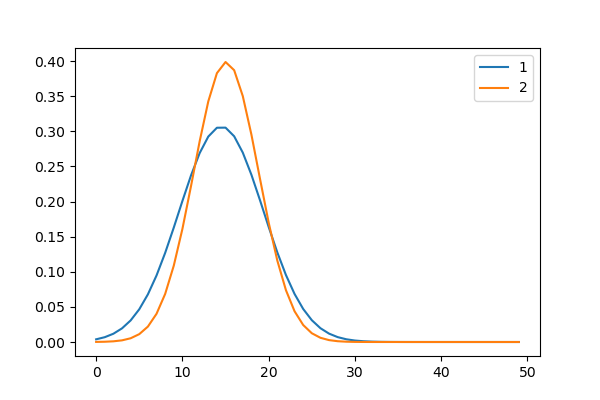

In [60]:
mean1 = 0.85
sigma1 = 1.3

mean2 = 1
sigma2 = 1

x_line = np.linspace(-3, 10)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(6, 4))
axes.plot(sstats.norm.pdf(x_line, mean1, sigma1), label='1')
axes.plot(sstats.norm.pdf(x_line, mean2, sigma2), label='2')
axes.legend()

In [61]:
compute_univariate_gaussian_kl_div(mean1, np.log(sigma1), mean2, np.log(sigma2))

0.09388573553250901